In [87]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
import os
import datetime
import numpy as np
import shap

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier

In [88]:
df = pd.read_csv('./Data/BTC-USDT_Data/BTC-USDT_Data_1m/BTC_USDT_1m_All.csv')
df

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,Symbol
0,2017-08-17 13:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,7.564907e+03,3,0.075183,3.203909e+02,BTCUSDT
1,2017-08-17 13:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000e+00,0,0.000000,0.000000e+00,BTCUSDT
2,2017-08-17 13:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,1.117543e+03,2,0.261074,1.117543e+03,BTCUSDT
3,2017-08-17 13:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,5.117185e+01,3,0.012008,5.117185e+01,BTCUSDT
4,2017-08-17 13:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,5.999993e+02,1,0.140796,5.999993e+02,BTCUSDT
...,...,...,...,...,...,...,...,...,...,...,...
2817383,2022-12-31 23:55:00,16582.94,16596.00,16582.82,16594.89,201.694600,3.345834e+06,3245,125.003820,2.073599e+06,BTCUSDT
2817384,2022-12-31 23:56:00,16594.89,16598.00,16589.41,16595.37,137.153070,2.275849e+06,3124,66.610050,1.105296e+06,BTCUSDT
2817385,2022-12-31 23:57:00,16595.37,16596.45,16591.73,16595.07,62.508600,1.037282e+06,2086,31.996350,5.309577e+05,BTCUSDT
2817386,2022-12-31 23:58:00,16594.39,16595.08,16592.24,16593.67,44.594320,7.399709e+05,1529,23.273400,3.861846e+05,BTCUSDT


In [89]:
df['Return'] = df['Close'].pct_change() # Return 계산
df['Maximum Hour Return'] = df['Return'].rolling(window=60).max() # Calculate maximum return
df['Price Volatility'] = df['Close'].rolling(window=60).std() # Minutewise price volatility
df['Return Volatility'] = df['Return'].rolling(window=60).std()  # Minutewise return volatility
for n in [60, 180, 240, 720, 1440]:  # 1, 3, 6, 12, 24 hours *Calculate momentums
    df[f'Momentum {n//60}H'] = df['Close'].pct_change(n)
df['Maximum Daily Return'] = df['Return'].rolling(window=2880).max()
df['Avg Price'] = df['Close'].rolling(window=60).mean() # Calculate average return for 1 hour

In [90]:
df = df.tail(100000)
df

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,...,Maximum Hour Return,Price Volatility,Return Volatility,Momentum 1H,Momentum 3H,Momentum 4H,Momentum 12H,Momentum 24H,Maximum Daily Return,Avg Price
2717388,2022-10-23 13:20:00,19199.10,19200.05,19198.31,19199.33,31.13612,5.977880e+05,1091,13.94139,2.676654e+05,...,0.000190,4.249780,0.000081,-0.000064,0.001098,-0.000328,-0.000716,0.002669,0.003045,19195.018333
2717389,2022-10-23 13:21:00,19199.31,19204.90,19198.47,19202.57,108.60104,2.085306e+06,2194,60.22025,1.156331e+06,...,0.000190,4.282873,0.000084,0.000062,0.001292,-0.000091,-0.000530,0.002774,0.003045,19195.038333
2717390,2022-10-23 13:22:00,19201.57,19205.11,19201.00,19203.40,88.87642,1.706694e+06,2027,44.40141,8.526561e+05,...,0.000190,4.398378,0.000081,0.000268,0.001362,0.000051,-0.000502,0.002938,0.003045,19195.124167
2717391,2022-10-23 13:23:00,19203.40,19204.42,19199.65,19201.43,54.33883,1.043414e+06,1908,18.70133,3.591085e+05,...,0.000190,4.452930,0.000082,0.000155,0.001339,0.000039,-0.000308,0.002711,0.003045,19195.173667
2717392,2022-10-23 13:24:00,19201.73,19203.21,19200.57,19203.18,23.53928,4.519976e+05,1263,13.64247,2.619630e+05,...,0.000190,4.560884,0.000083,0.000288,0.001280,0.000044,0.000481,0.002527,0.003045,19195.265667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817383,2022-12-31 23:55:00,16582.94,16596.00,16582.82,16594.89,201.69460,3.345834e+06,3245,125.00382,2.073599e+06,...,0.000847,13.664047,0.000264,0.000275,0.001428,0.001912,0.001049,0.012363,0.001776,16610.233333
2817384,2022-12-31 23:56:00,16594.89,16598.00,16589.41,16595.37,137.15307,2.275849e+06,3124,66.61005,1.105296e+06,...,0.000847,13.659960,0.000262,0.000013,0.001449,0.001979,0.001031,0.012452,0.001776,16610.237000
2817385,2022-12-31 23:57:00,16595.37,16596.45,16591.73,16595.07,62.50860,1.037282e+06,2086,31.99635,5.309577e+05,...,0.000847,13.730503,0.000259,-0.000266,0.001457,0.001966,0.001012,0.012104,0.001776,16610.163500
2817386,2022-12-31 23:58:00,16594.39,16595.08,16592.24,16593.67,44.59432,7.399709e+05,1529,23.27340,3.861846e+05,...,0.000847,13.838204,0.000260,-0.000403,0.001551,0.001771,0.001091,0.011357,0.001776,16610.052000


In [91]:
print(df.columns)

Index(['Open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'quote_av',
       'trades', 'tb_base_av', 'tb_quote_av', 'Symbol', 'Return',
       'Maximum Hour Return', 'Price Volatility', 'Return Volatility',
       'Momentum 1H', 'Momentum 3H', 'Momentum 4H', 'Momentum 12H',
       'Momentum 24H', 'Maximum Daily Return', 'Avg Price'],
      dtype='object')


Text(0, 0.5, 'price')

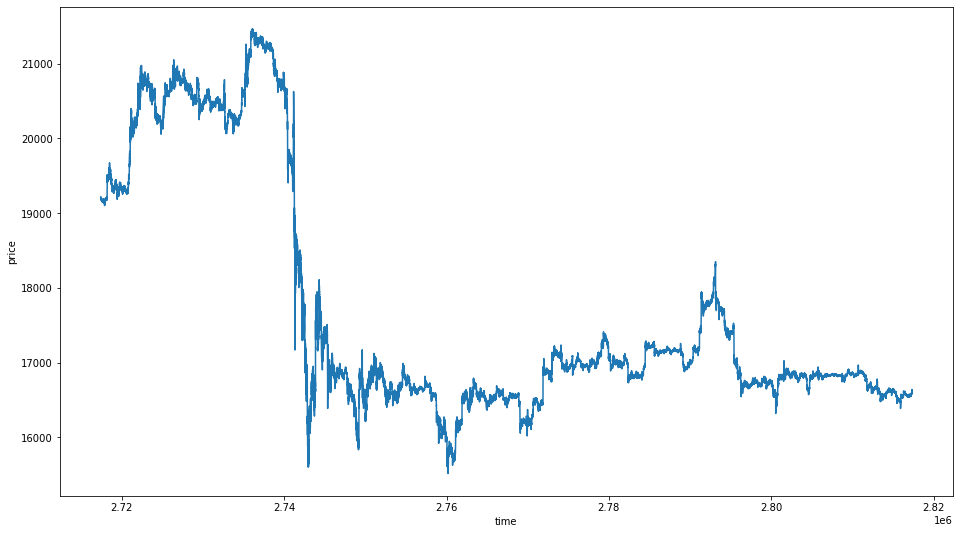

In [92]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['Close'], x=df.index)
plt.xlabel('time')
plt.ylabel('price')

In [93]:
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'quote_av',
       'trades', 'tb_base_av', 'tb_quote_av', 'Return',
       'Maximum Hour Return', 'Price Volatility', 'Return Volatility',
       'Momentum 1H', 'Momentum 3H', 'Momentum 4H', 'Momentum 12H',
       'Momentum 24H', 'Maximum Daily Return', 'Avg Price']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])

df = pd.DataFrame(scaled, columns=scale_cols)

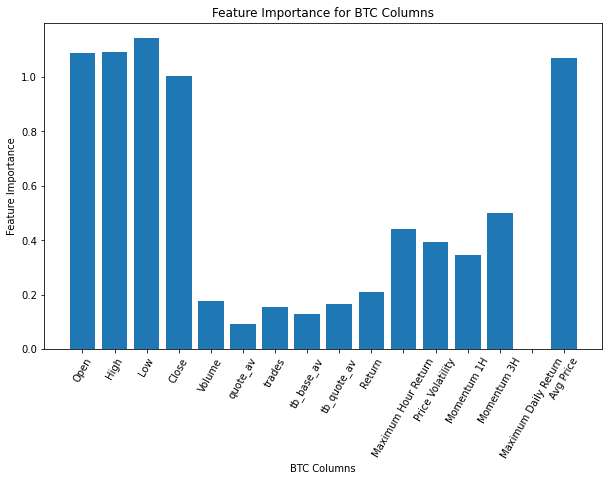

===Whole added===

Open: 0.7921057900911526

High: 0.6221608699627044

Low: 0.8553386694466957

Close: 0.788842537673555

Volume: 0.17113324624077797

quote_av: 0.11967316729241491

trades: 0.2946143228490589

tb_base_av: 0.19124374753769535

tb_quote_av: 0.2537567786780222

Return: 0.147902398393098

Maximum Hour Return: 0.9400607375929002

Price Volatility: 0.7667738605933677

Momentum 1H: 0.5907545027399743

Momentum 3H: 0.8688206035287378

Maximum Daily Return: 0.0

Avg Price: 1.982308777268036

Top 10 features are  ['Avg Price' 'Maximum Hour Return' 'Momentum 3H' 'Low' 'Open' 'Close'
 'Price Volatility' 'High' 'Momentum 1H' 'trades']

In [94]:
# 필요한 열만 선택하여 df를 수정합니다.
columns_to_keep =  ['Avg Price', 'Open', 'High', 'Close', 'Low', 'Momentum 3H','Maximum Hour Return', 'Price Volatility', 'Momentum 1H', 'tb_quote_av']
df = df[columns_to_keep]
df

,Avg Price,Open,High,Close,Low,Momentum 3H,Maximum Hour Return,Price Volatility,Momentum 1H,tb_quote_av
0,0.610206,0.619008,0.615814,0.619018,0.622279,0.661773,0.001886,0.007284,0.571149,0.004101
1,0.610210,0.619044,0.616631,0.619562,0.622306,0.662552,0.001886,0.007359,0.571963,0.020867
2,0.610224,0.619423,0.616666,0.619701,0.622729,0.662834,0.001886,0.007620,0.573293,0.015137
3,0.610233,0.619731,0.616550,0.619371,0.622503,0.662742,0.001886,0.007744,0.572559,0.005826
4,0.610249,0.619450,0.616346,0.619665,0.622657,0.662504,0.001886,0.007988,0.573417,0.003993
...,...,...,...,...,...,...,...,...,...,...
99995,0.160537,0.179575,0.177139,0.181574,0.185033,0.663100,0.016262,0.028603,0.573339,0.038172
99996,0.160537,0.181583,0.177476,0.181655,0.186135,0.663188,0.016262,0.028594,0.571645,0.019904
99997,0.160524,0.181663,0.177215,0.181604,0.186523,0.663217,0.016262,0.028753,0.569842,0.009068
99998,0.160505,0.181499,0.176984,0.181369,0.186608,0.663597,0.016262,0.028997,0.568955,0.006337


In [95]:
# 모델 생성 함수

def create_model(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=8, padding="causal", activation="relu", input_shape=input_shape),
        LSTM(16, activation='tanh'),
        Dense(16, activation="relu"),
        Dense(1)
    ])
    loss = Huber()
    optimizer = Adam(0.00005)
    model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
    return model


In [96]:
def windowed_dataset(x, y, window_size, batch_size, shuffle):
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))
    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [97]:
# Parameters
WINDOW_SIZE = 5
BATCH_SIZE = 32


In [98]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(df, df['Close'], test_size=0.1, random_state=0, shuffle=False)


In [99]:
from sklearn.metrics import mean_squared_error

In [100]:
predicted = []

for i in range(1, 11):
    train_data = windowed_dataset(x_train, y_train, WINDOW_SIZE + i - 1, BATCH_SIZE, True)
    model = create_model([WINDOW_SIZE + i - 1, df.shape[1]])
    earlystopping = EarlyStopping(monitor='loss', patience=5)
    filename = os.path.join('tmp', f'ckeckpointer_step_{i}.ckpt')
    checkpoint = ModelCheckpoint(filename, 
                                 save_weights_only=True, 
                                 save_best_only=True, 
                                 monitor='loss', 
                                 verbose=1)
    history = model.fit(train_data, epochs=20, callbacks=[checkpoint, earlystopping])

    model.load_weights(filename)
    window = x_train[-(WINDOW_SIZE + i - 1):].values.reshape(1, WINDOW_SIZE + i - 1, -1)
    pred = model.predict(window)
    predicted.append(pred[0, 0])

Epoch 1/20
   2802/Unknown - 12s 3ms/step - loss: 0.0108 - mse: 0.0216
Epoch 1: loss improved from inf to 0.01074, saving model to tmp\ckeckpointer_step_1.ckpt
2813/2813 [==============================] - 12s 3ms/step - loss: 0.0107 - mse: 0.0215
Epoch 2/20
2800/2813 [============================>.] - ETA: 0s - loss: 3.9220e-05 - mse: 7.8441e-05
Epoch 2: loss improved from 0.01074 to 0.00004, saving model to tmp\ckeckpointer_step_1.ckpt
2813/2813 [==============================] - 10s 3ms/step - loss: 3.9057e-05 - mse: 7.8113e-05
Epoch 3/20
2803/2813 [============================>.] - ETA: 0s - loss: 1.6721e-05 - mse: 3.3443e-05
Epoch 3: loss improved from 0.00004 to 0.00002, saving model to tmp\ckeckpointer_step_1.ckpt
2813/2813 [==============================] - 10s 3ms/step - loss: 1.6672e-05 - mse: 3.3344e-05
Epoch 4/20
2801/2813 [============================>.] - ETA: 0s - loss: 1.0876e-05 - mse: 2.1752e-05
Epoch 4: loss improved from 0.00002 to 0.00001, saving model to tmp\ckeckp

In [101]:
print(f"Predicted values: {predicted}")
print(f"Actual values: {y_test[:10].values}")
print(f"MSE: {mean_squared_error(y_test[:10].values, predicted)}")

Predicted values: [0.22150414, 0.2210283, 0.22141092, 0.22156811, 0.22181055, 0.22117504, 0.22118232, 0.22102702, 0.22112952, 0.22100633]
Actual values: [0.2215403  0.22188294 0.22176705 0.22196692 0.22181408 0.22204418
 0.22204418 0.22152183 0.22140257 0.22159405]
MSE: 3.180638871635028e-07


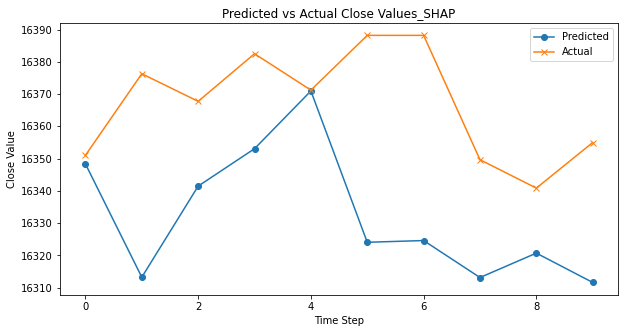

In [111]:
import matplotlib.pyplot as plt

# predicted와 y_test[:5]를 73806으로 곱함
predicted_scaled = [p * 73806 for p in predicted[:10]]
actual_scaled = [a * 73806 for a in y_test[:10].values]

# 그래프를 그림
plt.figure(figsize=(10, 5))
plt.plot(predicted_scaled, label="Predicted", marker='o')
plt.plot(actual_scaled, label="Actual", marker='x')
plt.xlabel('Time Step')
plt.ylabel('Close Value')
plt.legend()
plt.title('Predicted vs Actual Close Values_SHAP')
plt.show()

# Bollinger

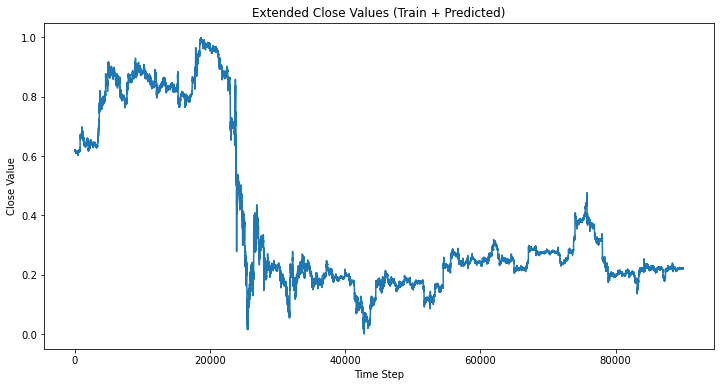

Buy Signals: [89961, 89962, 89964, 89987, 89988, 89989, 89990, 89991, 90007, 90009]
Sell Signals: [89974, 89975, 89982, 89983, 89985, 89996, 89997, 90000, 90003, 90004]
Profit: 80.82971226284218


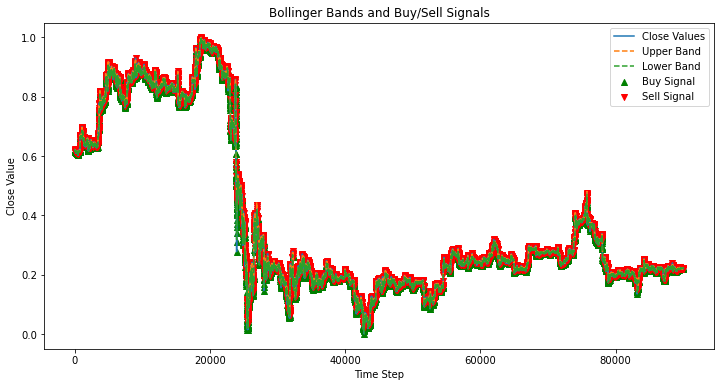

In [112]:
import numpy as np

# Append predicted close values to train close values
extended_close_values = np.concatenate((x_train['Close'].values, predicted))

# Plot the extended close values
plt.figure(figsize=(12, 6))
plt.plot(extended_close_values)
plt.title('Extended Close Values (Train + Predicted)')
plt.xlabel('Time Step')
plt.ylabel('Close Value')
plt.show()

# Calculate the Bollinger Bands
window_size = 10
ma = pd.Series(extended_close_values).rolling(window=window_size).mean()
std = pd.Series(extended_close_values).rolling(window=window_size).std()
upper_band = ma + std
lower_band = ma - std

# Generate buy and sell signals
buy_signals = []
sell_signals = []
for i in range(window_size, len(extended_close_values)):
    if extended_close_values[i] < lower_band[i]:
        buy_signals.append(i)
    elif extended_close_values[i] > upper_band[i]:
        sell_signals.append(i)

# Calculate the profit/loss from the buy and sell signals
profit = 0
for i in range(len(buy_signals) - 1):
    buy_price = extended_close_values[buy_signals[i]]
    sell_price = extended_close_values[sell_signals[i]]
    profit += sell_price - buy_price

# Display the signals and profit
print('Buy Signals:', buy_signals[-10:])
print('Sell Signals:', sell_signals[-10:])
print('Profit:', profit)

# Display the Bollinger Bands and signals
plt.figure(figsize=(12, 6))
plt.plot(extended_close_values, label='Close Values')
plt.plot(upper_band, label='Upper Band', linestyle='--')
plt.plot(lower_band, label='Lower Band', linestyle='--')
plt.scatter(buy_signals, [extended_close_values[i] for i in buy_signals], marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter(sell_signals, [extended_close_values[i] for i in sell_signals], marker='v', color='r', label='Sell Signal', alpha=1)
plt.title('Bollinger Bands and Buy/Sell Signals')
plt.xlabel('Time Step')
plt.ylabel('Close Value')
plt.legend()
plt.show()


In [113]:
# Multiply all values by 73806
scaled_extended_close_values = extended_close_values * 73806
scaled_upper_band = upper_band * 73806
scaled_lower_band = lower_band * 73806

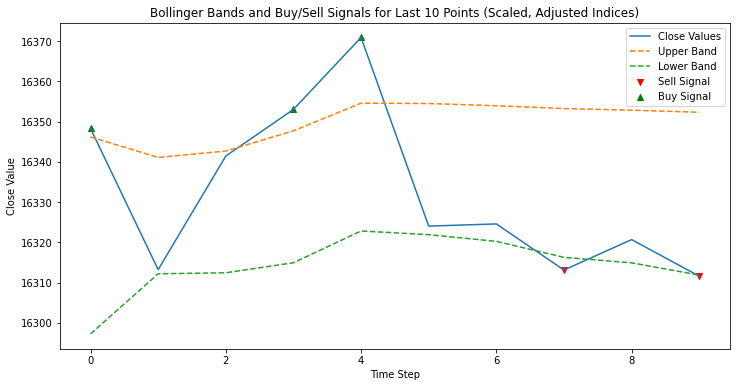

In [114]:
# Adjust the indices for the upper and lower bands to align with the last 10 data points
adjusted_upper_band = scaled_upper_band[-10:].reset_index(drop=True)
adjusted_lower_band = scaled_lower_band[-10:].reset_index(drop=True)

# Adjust the indices for the buy and sell signals
adjusted_buy_signals = [i - len(scaled_extended_close_values) + 10 for i in buy_signals if i >= len(scaled_extended_close_values) - 10]
adjusted_sell_signals = [i - len(scaled_extended_close_values) + 10 for i in sell_signals if i >= len(scaled_extended_close_values) - 10]

# Display the last 10 data points with adjusted indices
plt.figure(figsize=(12, 6))
plt.plot(scaled_extended_close_values[-10:], label='Close Values')
plt.plot(adjusted_upper_band, label='Upper Band', linestyle='--')
plt.plot(adjusted_lower_band, label='Lower Band', linestyle='--')

# Change the labels and colors for buy and sell signals
plt.scatter(adjusted_buy_signals, [scaled_extended_close_values[i] for i in buy_signals if i >= len(scaled_extended_close_values) - 10], 
            marker='v', color='r', label='Sell Signal', alpha=1)
plt.scatter(adjusted_sell_signals, [scaled_extended_close_values[i] for i in sell_signals if i >= len(scaled_extended_close_values) - 10], 
            marker='^', color='g', label='Buy Signal', alpha=1)

plt.title('Bollinger Bands and Buy/Sell Signals for Last 10 Points (Scaled, Adjusted Indices)')
plt.xlabel('Time Step')
plt.ylabel('Close Value')
plt.legend()
plt.show()


In [115]:
# Initialize variables to keep track of capital and positions
capital = 100000  # Initial capital (you can set this to your starting capital)
position = 0  # The current position (0 means no position, 1 means long, -1 means short)
btc_qty = 1  # Number of bitcoins to buy/sell

# Iterate through the last 10 data points
for i in range(-10, 0):
    close_value = scaled_extended_close_values[i]
    upper_value = scaled_upper_band[i + 10] # Adjusted index
    lower_value = scaled_lower_band[i + 10] # Adjusted index
    
    # Check for buy signal
    if close_value > upper_value and position == 0:
        capital -= close_value * btc_qty
        position = 1
    
    # Check for sell signal
    elif close_value < lower_value and position == 0:
        capital += close_value * btc_qty
        position = -1
        
    # Check for position closure for long
    elif position == 1 and close_value < upper_value:
        capital += close_value * btc_qty
        position = 0
        
    # Check for position closure for short
    elif position == -1 and close_value > lower_value:
        capital -= close_value * btc_qty
        position = 0

# Calculate the returns
returns = (capital - 100000) / 100000 * 100

print(f'The returns from the last 10 time steps is {returns}%')


The returns from the last 10 time steps is 16.311593474507333%


In [116]:
from math import sqrt

In [118]:
# Calculate RMSE for PCA
predicted_scaled_ary = np.array([p * 73806 for p in predicted[:10]])
actual_scaled_ary = np.array([a * 73806 for a in y_test[:10].values])
rmse_shap = sqrt(mean_squared_error(predicted_scaled_ary, actual_scaled_ary))
print('RMSE for SHAP:', rmse_shap)

RMSE for SHAP: 41.6244827767454


In [120]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Convert the lists to arrays
predicted_scaled_ary = np.array([p * 73806 for p in predicted[:10]])
actual_scaled_ary = np.array([a * 73806 for a in y_test[:10].values])

# Calculate MAE
mae = mean_absolute_error(actual_scaled_ary, predicted_scaled_ary)
print('MAE:', mae)

# Calculate SMAPE
smape_numerator = np.abs(predicted_scaled_ary - actual_scaled_ary)
smape_denominator = (np.abs(actual_scaled_ary) + np.abs(predicted_scaled_ary)) / 2
smape = 100 * np.mean(smape_numerator / smape_denominator)
print('SMAPE:', smape)

MAE: 34.95352554068304
SMAPE: 0.21380844569818086
